In [1]:
# !apt-get update --fix-missing

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake

Having demosntrated how to construct the CDF $F_Y(y)$ of a random function $Y(\boldsymbol{x})$ we now develop a means to obtain the inverse CDF $F^{-1}_Y(p)$ also known as the quantile density function or QDF $Q_Y(p)$. When estimating the available potential energy (APE) via the buoyancy PDF/CDF, the QDF of domain height is used to account for how much buoyancy is located at each height and thus forms an essential component of this calculation.

To demonstrate our method of constructing the QDF, we choose the function $Y(x_1) = x$ on the interval $x_1 \in [0,1]$. To further simplify the presentation we will use the **PDF_Projector** class (imported below) to obtain the CDF of this function.

In [2]:
from PDF_Projector import *

We begin by creating an instance of the FEptp class specifying the function space of the CDF to be the piecewise linear discontinuous space "DG1". As we are interested in only the QDF $Q_Y(p) = F^{-1}_Y(p)$ the function space of the PDF is unimportant as we will not be using it here.

In [3]:
# Specify the function spaces for the CDF
ptp = FEptp(func_space_CDF = {"family":"DG","degree":1})

With the function spaces set, we must then specify the phyiscal domain $\Omega_X$, the domain of the CDF $\Omega_Y$ and the number of elements we will use. This is done by calling the domain method

In [4]:
x1,y = ptp.domain(Omega_X = {'x1':(0,1)}, Omega_Y = {'Y':(0,1)}, N_elements=3)

1D mesh


/home/pmannix/Dstratify/Finite_Element/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


which returns the co-ordinates of the domain $x_1,y$. Armed with the co-ordinates we can then specify our function $Y(x_1)$ and generate the CDF & PDF by calling the fit method

In [5]:
ptp.fit(function_Y = x1, quadrature_degree=10)

Calculated ∫ f(y) dy should equal 1, but got 9.799796e-01. Check the quadrature_degree used. 


Once fitted we can then plot the CDF functions by calling the plot method

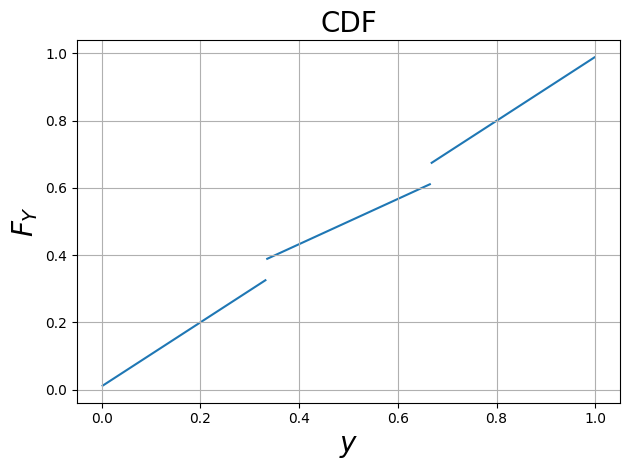

In [6]:
ptp.plot(function='CDF')

By choosing a small number of elements and a similarly low order quadrature we have intentionally generated a poor approximation of the CDF, which although monotonically increasing this function is discontinous between cells. Importantly this example highlights that well mixed regions of the CDF exist for which one value of $y*$ has associated to it a range of probabilities $\Omega^*_Y = [\text{min}(F_Y(y*)),\text{max}(F_Y(y*))]$. To obtain a consistent QDF we must therefore construct a function capable of mapping $Q_Y : \Omega^*_Y \to p$. 

A perfect candidate for the QDF is a discontinuous piecewise linear function $Q_Y(p)$ on a non-uniform mesh $\Omega_p$, whose spacing is determined by the discontinuities of $F_Y$. We can therefore use the dofs $F_i = F(y_i)$ at the node values $y_i$ on the cell boundaries to prescribe the non-uniform mesh $\Omega_p$ on which $Q_Y$ is defined.

In [7]:
# Construct the non-uniform domain Ω_p

# Obtain dofs F_i = F(z_i) from the CDF
F_i = ptp.F.dat.data[:] 

# We extend Ω_p to include the endpoints 0,1
# As F(y=0) ≠ 0 & F(y=1) ≠ 1 due to numerical error  
p   = np.hstack(( [0]     ,F_i,[1]       ))  

# Make a 1D mesh whose vertices are given by the p values
layers   = len(p[1:] - p[:-1]);
ptp.m_p = UnitIntervalMesh(ncells=layers);
ptp.m_p.coordinates.dat.data[:] = p[:]

print('Ω_p cell boundaries = ',ptp.m_p.coordinates.dat.data[:])

Ω_p cell boundaries =  [0.         0.0100102  0.32701903 0.38787271 0.61212729 0.67298097
 0.9899898  1.        ]


We then define the function $Q_Y(p)$ on this mesh, by using the function space $V_F$ as specified by the finite element *V_FE* whose details are printed below.

In [8]:
# Create a function Q(p) on this mesh
ptp.V_Q  = FunctionSpace(mesh=ptp.m_p,family=ptp.V_FE)
ptp.Q    = Function(ptp.V_Q)

print(ptp.V_Q.ufl_function_space)

<bound method WithGeometryBase.ufl_function_space of WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f6b94eafc50>, FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 29))>


Set the values of the QDF $Q_Y(F_i) = Q_Y(F(y_i)) = y_i$ by passing it the coordinates of the CDF's mesh corresponding to each $F_i$.

In [9]:
# Extract the mesh coordinates of the CDF
m_y = ptp.V_F.mesh()
W   = VectorFunctionSpace(m_y, ptp.V_F.ufl_element())
y_m = assemble(interpolate(m_y.coordinates, W)).dat.data

# Double them to convert from mesh coordinates to DOFs
y_i         = np.zeros(2*len(y_m))
y_i[0:-1:2] = y_m
y_i[1:  :2] = y_m

# Append the coordinates of the boundaries
y_l = m_y.coordinates.dat.data[ 0] # left endpoint
y_r = m_y.coordinates.dat.data[-1] # right endpoint
y_i = np.hstack(( [y_l],y_i,[y_r] )) 

# Assign Q(F_i) = y_i
ptp.Q.dat.data[:] = y_i[:]

Finally we can plot the QDF $Q_Y = F^{-1}_Y$ and compare it with its corresponding CDF $F_Y$

In [ ]:
ptp.plot(function='CDF')
ptp.plot(function='QDF')